In [2]:
from youtube_transcript_api import YouTubeTranscriptApi
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from matplotlib import dates as mpl_dates
from googleapiclient.discovery import build
import os
import pandas as pd
import seaborn as sns
import urllib.request

In [2]:
api_key = 'INSERT API KEY'
youtube = build('youtube', 'v3', developerKey=api_key)

In [3]:
channel_urls = ['https://www.youtube.com/c/CoinBureau', 
                'https://www.youtube.com/channel/UCjemQfjaXAzA-95RKoy9n_g', # Bitboy 
                'https://www.youtube.com/c/AltcoinDaily', 
                'https://www.youtube.com/c/CryptosRUs', 
                'https://www.youtube.com/c/FUDTV', 
                'https://www.youtube.com/c/CryptoBanterGroup',
                'https://www.youtube.com/c/TheMoonCarl',
                'https://www.youtube.com/c/DataDash',
                'https://www.youtube.com/c/IvanonTech',
                'https://www.youtube.com/c/TheCryptoLark',
                'https://www.youtube.com/c/AnthonyPompliano',
                'https://www.youtube.com/c/CryptoCapitalVenture',
                'https://www.youtube.com/c/aantonop',
                'https://www.youtube.com/c/Boxmining',
                'https://www.youtube.com/c/CryptoZombie',
                'https://www.youtube.com/c/tonevays',
                'https://www.youtube.com/c/ScottMelker']

## Get `channel_id` from custom YouTube URL

E.g., https://www.youtube.com/c/CoinBureau --> https://www.youtube.com/channel/UCqK_GSMbpiV8spgD3ZGloSw

These links lead to the same place but the YouTube API requires the latter.

In [4]:
# Inspired by: https://gist.githubusercontent.com/stvar/f57e9792c3dc49fab2690247d6ee74de/raw/b665f4c0dbbcaa8adef4794dfe4923844e20e0ae/youtube-search.py
class Text:
    
    from unicodedata import normalize
    # https://stackoverflow.com/a/29247821/8327971
    
    @staticmethod
    def normalize_casefold(text):
        return Text.normalize("NFKD", text.casefold())

    @staticmethod
    def casefold_equal(text1, text2):
        return \
            Text.normalize_casefold(text1) == \
            Text.normalize_casefold(text2)

def find_channel_by_custom_url(url):
    resp = youtube.search().list(
        q = url,
        part = 'id',
        type = 'channel',
        fields = 'items(id(kind,channelId))',
        maxResults = 10
    ).execute()

    items = resp['items']
    assert len(items) <= 10

    ch = []
    for item in items:
        assert item['id']['kind'] == 'youtube#channel'
        ch.append(item['id']['channelId'])

    if not len(ch):
        return url

    resp = youtube.channels().list(
        id = ','.join(ch),
        part = 'id,snippet',
        fields = 'items(id,snippet(customUrl))',
        maxResults = len(ch)
    ).execute()

    items = resp['items']
    assert len(items) <= len(ch)

    for item in items:
        cust = item['snippet'].get('customUrl')
        if cust is not None and \
            Text.casefold_equal(cust, url):
            assert item['id'] is not None
            return item['id']

    return url

# Now convert channel_urls to channel_ids
channel_ids = [find_channel_by_custom_url(channel.split('/')[-1]) for channel in channel_urls]

## Get channel statistics

,Channel_name,Subscribers,Views,Total_videos,playlist_id
0,Altcoin Daily,1230000,126721573,1783,UUbLhGKVY-bJPcawebgtNfbw
1,The Moon,560000,86768713,1738,UUc4Rz_T9Sb1w5rqqo9pL1Og
2,Ivan on Tech,493000,24208472,907,UUrYmtJBtLdtm2ov84ulV-yg
3,Tone Vays,121000,12847817,1242,UUbiWJYRg8luWHnmNkJRZEnw
4,BitBoy Crypto,1450000,207401248,3136,UUjemQfjaXAzA-95RKoy9n_g
5,Lark Davis,487000,55589219,1920,UUl2oCaw8hdR_kbqyqd2klIA
6,Boxmining,268000,17960348,651,UUxODjeUwZHk3p-7TU-IsDOA
7,Crypto Zombie,239000,31556323,1155,UUiUnrCUGCJTCC7KjuW493Ww
8,CryptosRUs,647000,99977134,1193,UUI7M65p3A-D3P4v5qW8POxQ
9,Coin Bureau,2080000,147179199,728,UUqK_GSMbpiV8spgD3ZGloSw


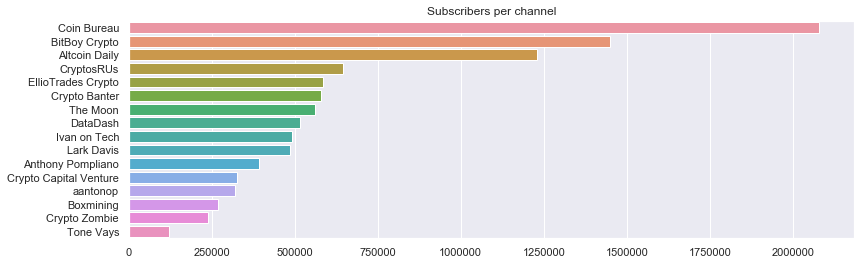

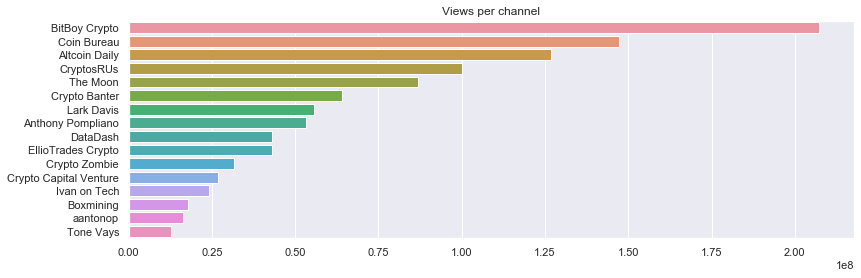

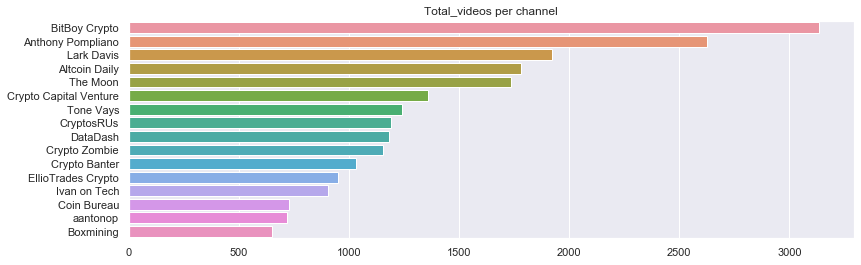

In [83]:
# Function to get channel statistics
def get_channel_stats(youtube, channel_ids):
    all_data = []
    request = youtube.channels().list(
        part = 'snippet,contentDetails,statistics',
        id=','.join(channel_ids))
    response = request.execute()
    
    for i in range(len(response['items'])):
        data = dict(Channel_name = response['items'][i]['snippet']['title'],
                    Subscribers = response['items'][i]['statistics']['subscriberCount'],
                    Views = response['items'][i]['statistics']['viewCount'],
                    Total_videos = response['items'][i]['statistics']['videoCount'],
                    playlist_id = response['items'][i]['contentDetails']['relatedPlaylists']['uploads'])
        all_data.append(data)
    return all_data


# Get channel statistics
channel_statistics = get_channel_stats(youtube, channel_ids)
channel_data = pd.DataFrame(channel_statistics)
# Convert cols to int64
for col in ['Subscribers', 'Views', 'Total_videos']:
    channel_data[col] = pd.to_numeric(channel_data[col])
display(channel_data)


# Plot channel statistcs
sns.set(rc={'figure.figsize':(13,4)})

x = 'Subscribers'
ax = sns.barplot(x=x, y='Channel_name', data=channel_data.sort_values(by=x, ascending=False))
ax.set(ylabel=None,xlabel=None, title='%s per channel'%x)
plt.show()

x = 'Views'
ax = sns.barplot(x=x, y='Channel_name', data=channel_data.sort_values(by=x, ascending=False))
ax.set(ylabel=None,xlabel=None, title='%s per channel'%x)
plt.show()

x = 'Total_videos'
ax = sns.barplot(x=x, y='Channel_name', data=channel_data.sort_values(by=x, ascending=False))
ax.set(ylabel=None,xlabel=None, title='%s per channel'%x)
plt.show()

## Get video ids for a particular YouTube channel

This returns a dictionary where keys are `channel_names` and values is the complete list of `video_ids` from that channel.

In [84]:
def get_video_ids(youtube, channel_data):
    
    channel_names = list(channel_data['Channel_name'])
    playlist_ids = list(channel_data['playlist_id'])
    
    video_ids = {}
    for channel_name, playlist_id in zip(channel_names, playlist_ids):
        request = youtube.playlistItems().list(
                    part='contentDetails', 
                    playlistId=playlist_id, maxResults = 5000)
        response = request.execute()


        id_list = []
        for i in range(len(response['items'])):
            id_list.append(response['items'][i]['contentDetails']['videoId'])


        next_page_token = response.get('nextPageToken')
        more_pages = True

        while more_pages:
            if next_page_token is None:
                more_pages = False
            else:
                request = youtube.playlistItems().list(
                            part='contentDetails', 
                            playlistId=playlist_id, 
                            maxResults = 5000, 
                            pageToken = next_page_token)
                response = request.execute()

            for i in range(len(response['items'])):
                id_list.append(response['items'][i]['contentDetails']['videoId'])
            next_page_token = response.get('nextPageToken')
    
        video_ids[channel_name] = id_list
    return video_ids

In [85]:
video_ids = get_video_ids(youtube, channel_data)

## Get video statistics for a list of `video_ids`

In [94]:
def get_video_stats(youtube, video_ids):
    all_video_stats = []
    
    for i in range(0,len(video_ids),50):
        request = youtube.videos().list(part='snippet, statistics',
                                      id=','.join(video_ids[i:i+50]))
        response = request.execute()
    
        for video in response['items']:
            video_stats = dict(Title = video['snippet']['title'], 
                               Published_date = video['snippet']['publishedAt'], 
                               Views = video['statistics']['viewCount'],
                               #Likes = video['statistics']['likeCount'],
                               #Comments = video['statistics']['commentCount'],
                              )
            
            all_video_stats.append(video_stats)
            
    all_video_stats = pd.DataFrame(all_video_stats)
    # Convert date col to datetime object
    all_video_stats['Published_date'] = pd.to_datetime(all_video_stats['Published_date'])#.dt.date
    # Convert other columns to numeric
    #for col in ['Views', 'Likes', 'Comments']:
    for col in ['Views']:
        all_video_stats[col] = pd.to_numeric(all_video_stats[col])
    
    return all_video_stats

## Example: Top-10 performing BitBoy Crypto videos

In [95]:
video_stats = get_video_stats(youtube, video_ids['BitBoy Crypto'])

,Title,Published_date,Views
1663,Top 3 Coins To $3 Million (NFT Picks To Become...,2021-03-19 22:00:08+00:00,852946
1649,My $10 Million Crypto Portfolio REVEALED (Shoc...,2021-03-24 23:00:12+00:00,799773
1652,5 CHEAPEST Altcoins to Make You RICH (Under a ...,2021-03-23 22:00:00+00:00,772590
839,Top 3 Altcoins to Buy RIGHT NOW! (PARABOLIC Cr...,2021-11-07 17:04:12+00:00,717068
1439,YOU RARELY GET A SECOND CHANCE LIKE THIS!,2021-06-02 19:45:56+00:00,629848
1792,Cardano 100x Moonshot (GREATEST ADA Price Pred...,2021-02-04 23:00:25+00:00,603252
1845,Chamath Palihapitiya Warns ETH Holders! (Ether...,2021-01-15 23:00:08+00:00,563492
1080,TOP 2 SUPER Altcoins to Make You RICH!,2021-09-11 22:11:32+00:00,519531
1836,Become an Ethereum Millionaire (Turn $800 into...,2021-01-19 23:00:26+00:00,500676
1501,"URGENT WARNING to ALL Bitcoin, Ethereum, & Car...",2021-05-13 01:21:30+00:00,487382


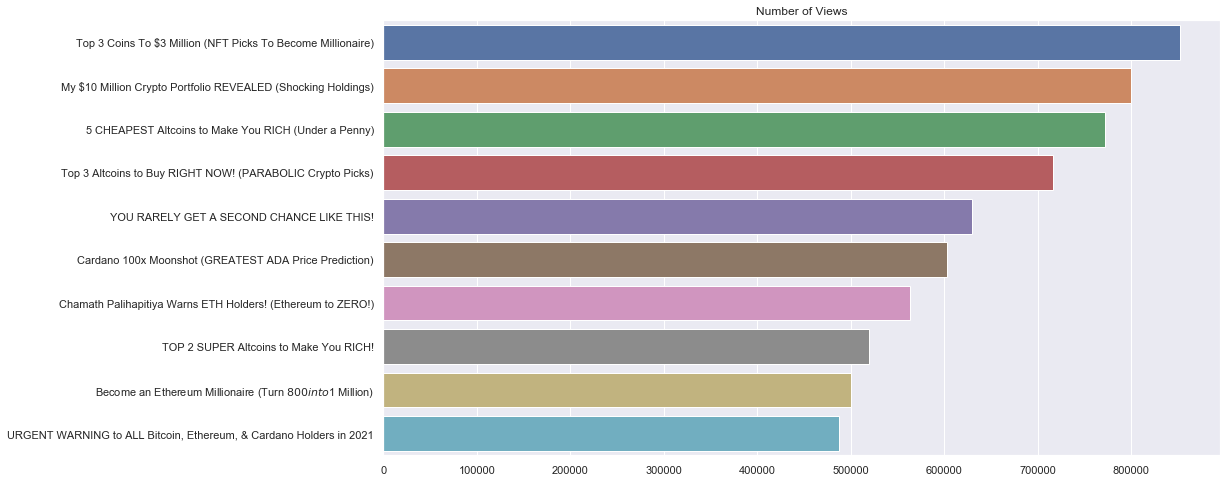

In [96]:
top10_videos = video_stats.sort_values(by='Views', ascending=False).head(10)
display(top10_videos)
sns.set(rc={'figure.figsize':(15,8)})
ax1 = sns.barplot(x='Views', y='Title', data=top10_videos)
ax1.set(ylabel=None,xlabel=None, title='Number of Views')
plt.show()

## Get video stats for each YouTube channel

In [104]:
for i,channel_name in enumerate(channel_data['Channel_name']):
    video_stats = get_video_stats(youtube, video_ids[channel_name])
    videos_per_month = video_stats.groupby([
                        video_stats['Published_date'].dt.year.rename('year'),
                        video_stats['Published_date'].dt.month.rename('month')]).size().reset_index(name=channel_name)
    videos_per_month['date'] = videos_per_month['month'].astype(str) + '/' + videos_per_month['year'].astype(str)
    videos_per_month['date'] = pd.to_datetime(videos_per_month['date'])
    videos_per_month.drop(['month', 'year'], axis=1, inplace=True)
    videos_per_month = videos_per_month.set_index('date')
    
    if i == 0:
        maindf = videos_per_month
    else:
        maindf = maindf.merge(videos_per_month, how='outer', left_index=True, right_index=True)

In [108]:
maindf = maindf.fillna(0)

In [109]:
maindf

,Altcoin Daily,The Moon,Ivan on Tech,Tone Vays,BitBoy Crypto,Lark Davis,Boxmining,Crypto Zombie,CryptosRUs,Coin Bureau,Crypto Capital Venture,Anthony Pompliano,DataDash,aantonop,Crypto Banter,EllioTrades Crypto
date,,,,,,,,,,,,,,,,
2015-02-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
2015-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
2015-07-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
2015-10-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
2015-11-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-01,36.0,33.0,0.0,24.0,112.0,26.0,6.0,17.0,74.0,27.0,26.0,119.0,19.0,5.0,83.0,6.0
2022-04-01,39.0,17.0,0.0,19.0,111.0,24.0,6.0,17.0,62.0,25.0,23.0,108.0,13.0,1.0,70.0,2.0
2022-05-01,38.0,40.0,4.0,27.0,108.0,19.0,6.0,21.0,63.0,26.0,37.0,112.0,18.0,0.0,60.0,8.0


## Example plot: Plotting YouTube posts over time, compared to Bitcoin price.

This is just an exercise to practice plotting these kinds of graphs. We can replace "number of posts" with other ideas, e.g., positive/negative sentiment, number of times a keyword is mentioned, and more. 

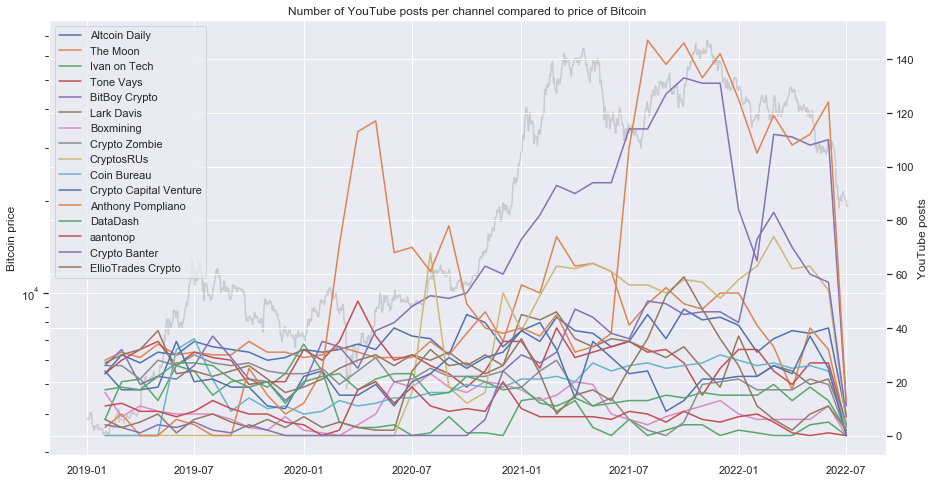

In [126]:
df = pd.read_csv('BCHAIN-MKPRU.csv')
df = df.iloc[::-1] # reverse order of dataframe
df['Date'] = pd.to_datetime(df['Date'])

# Drop all dates before this date. 
df = df[df['Date'] > '2019-01-01']

# Define figure
fig, ax1 = plt.subplots(figsize=(15,8))
ax2 = ax1.twinx()

# Plot BTC price
ax1.semilogy(df['Date'], df['Value'], color='grey', zorder=1, alpha=0.3)
ax1.set_ylabel('Bitcoin price')

maindf = maindf[maindf.index > '2019-01-01']
# Plot YouTube Channel posts per month
for channel_name in channel_data['Channel_name']:
    ax2.plot(maindf.index, maindf[channel_name], linestyle='solid', label=channel_name)

ax2.set_ylabel('YouTube posts')    
plt.legend()
plt.title('Number of YouTube posts per channel compared to price of Bitcoin')
plt.show()

## Natural language processing on YouTube videos

In [3]:
from wordcloud import WordCloud, STOPWORDS

In [4]:
# https://www.youtube.com/watch?v=gis10voYBcw
youtube_video_id = 'bfRhs62FK7c'
for i in YouTubeTranscriptApi.get_transcript(youtube_video_id):
    print(i['text'])
text = ' '.join([d['text'] for d in YouTubeTranscriptApi.get_transcript(youtube_video_id)])
tokens = nltk.tokenize.word_tokenize(text)

recently the ontario securities and
exchange commission set an annual limit
on how much regular canadians living in
the province can invest in altcoins
although this annual limit is not a
federal law it is part of a growing
trend to restrict retail investors from
cryptocurrency both in canada and
elsewhere today i'm going to tell you
why so many countries are starting to
make it difficult for retail investors
to access cryptocurrency and what
effects this could have on the crypto
market
now i want to start by taking you back
in time to the 1920s it's after the
first world war and the economies of
allied countries are booming
in the united states the stock market is
roaring to all-time highs and millions
of americans are investing their life
savings into stocks with many of them
borrowing to invest even more
fast forward to
1929 the economy is suddenly not looking
so good and the amount of debt that's
been taken on by speculators has hit
record highs but the stock market keeps
pumping s

In [5]:
# Stop words are common words that we don't want to analyze. Or, and, if, etc.
s = set(stopwords.words('english'))
tokens = [t for t in tokens if t not in s]

In [6]:
frequency = nltk.FreqDist(tokens)
frequency

FreqDist({'investors': 48, "'s": 45, 'retail': 39, 'crypto': 32, 'market': 27, 'stock': 23, "n't": 21, 'accredited': 16, 'sec': 15, 'cryptocurrency': 14, ...})

In [7]:
most_common = frequency.most_common(20)
most_common

[('investors', 48),
 ("'s", 45),
 ('retail', 39),
 ('crypto', 32),
 ('market', 27),
 ('stock', 23),
 ("n't", 21),
 ('accredited', 16),
 ('sec', 15),
 ('cryptocurrency', 14),
 ('trading', 12),
 ('make', 11),
 ('stocks', 10),
 ('even', 10),
 ('like', 10),
 ('year', 10),
 ('get', 9),
 ('one', 9),
 ('exchanges', 9),
 ('altcoins', 8)]

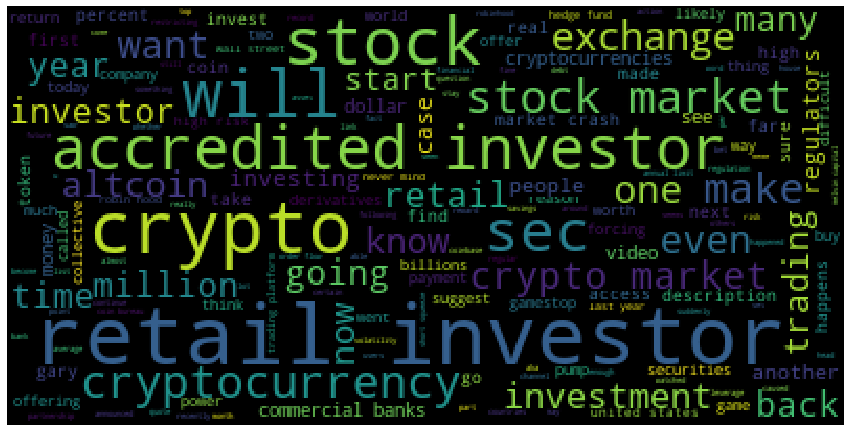

In [8]:
plt.figure(figsize=(15,15))
cloud = WordCloud(
        background_color='black',
        stopwords = STOPWORDS,
        )
cloud.generate(text)
plt.imshow(cloud)
plt.axis("off")
plt.show()